In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:


def compare_and_plot_forecast_vs_actual(data, forecast_data, store_number, sample_size=5, random_state=42):
    """
    Compare forecasted vs actual data for a specific store, sample SKUs, and plot results.
    
    Parameters:
        data (pd.DataFrame): Actual data containing units sold.
        forecast_data (pd.DataFrame): Forecasted data.
        store_number (int): Store number to filter data.
        group_column (str): Column to group by (e.g., SKU number).
        sample_size (int): Number of SKUs to sample for comparison.
        random_state (int): Seed for reproducibility of the random sample.

    Returns:
        pd.DataFrame: Comparison data for sampled SKUs.
    """
    # Filter data for the specific store
    store_data = data[data['Store_Number'] == store_number]
    forecast_data = forecast_data[forecast_data['Store'] == store_number]
    
    # Merge the actual data and forecasted data on Week (or date) and SKU
    comparison_data = pd.merge(
        store_data, 
        forecast_data, 
        on=['Week', 'SKU_Number'], 
        suffixes=('_actual', '_forecasted')
    )
    
    # Sample SKUs
    sampled_skus = comparison_data['SKU_Number'].drop_duplicates().sample(
        n=sample_size, 
        random_state=random_state
    )
    
    # Filter the comparison data for the sampled SKUs
    comparison_data = comparison_data[comparison_data['SKU_Number'].isin(sampled_skus)]
    
    # Create error columns (e.g., absolute error and percentage error)
    comparison_data['error'] = comparison_data['UNITS_SOLD'] - comparison_data['Forecasted_Units_Sold']
    comparison_data['abs_error'] = abs(comparison_data['error'])
    comparison_data['percent_error'] = (comparison_data['abs_error'] / comparison_data['UNITS_SOLD']) * 100

    # Plotting each sampled SKU
    for sku in sampled_skus:
        sku_data = comparison_data[comparison_data['SKU_Number'] == sku]
        plt.figure(figsize=(10, 6))
        plt.plot(sku_data['Week'], sku_data['UNITS_SOLD'], label='Actual Units Sold', marker='o', color='blue')
        plt.plot(sku_data['Week'], sku_data['Forecasted_Units_Sold'], label='Forecasted Units Sold', marker='x', color='orange')
        plt.title(f'Actual vs Forecasted Units Sold for SKU {sku}')
        plt.xlabel('Week')
        plt.ylabel('Units Sold')
        plt.legend()
        plt.grid(True)
        plt.show()

    return comparison_data


In [3]:

file_path = '/Users/anabellaisaro/Documents/Documents - Anabella’s MacBook Pro/Northwestern/Projects/Deloitte/forecast/data/'
file_path2 = '/Users/anabellaisaro/Documents/Documents - Anabella’s MacBook Pro/Northwestern/Projects/Deloitte/forecast/results/'
input_file_path = os.path.join(os.path.dirname(file_path), 'Capstone_Forecasting_Data_updated.csv')
input_data = pd.read_csv(input_file_path)
model_file_path = os.path.join(os.path.dirname(file_path2), 'forecasted_sales_SARIMA_dept-5.csv')
model_data = pd.read_csv(model_file_path)


In [4]:
input_data['Store_Location'] = input_data['Store_SKU'].str.split('_').str[1]
input_data['Store_Location'] = input_data['Store_Location'].astype(int, errors='ignore')  # Convert to int, ignore errors for non-convertible values
input_data['Store_Number'] = input_data['Store_SKU'].str.extract(r'(\d+)')
input_data['Store_Number'] = input_data['Store_Number'].astype(int, errors='ignore')  # Convert to int
input_data['SKU_Number'] = input_data['SKU'].str.extract(r'(\d+)')
input_data['SKU_Number'] = input_data['SKU_Number'].astype(int, errors='ignore')  # Convert to int
input_data['Week'] = pd.to_datetime(input_data['Week'], format='%m/%d/%y')

In [5]:
input_data.head()

,Store_SKU,Store_Num,Department,Category,SKU,Week,Net_Sales_Price,UNITS_SOLD,Ad,Display,Store_Location,Store_Number,SKU_Number
0,S1_Chicago_SKU_1,S1_Chicago,Home,Pajamas,SKU_1,2019-02-10,3.95,437,0,0,Chicago,1,1
1,S2_Milwaukee_SKU_2,S2_Milwaukee,Home,Bath,SKU_2,2019-02-10,4.53,1245,0,0,Milwaukee,2,2
2,S3_Minneapolis_SKU_3,S3_Minneapolis,Apparel,Mens,SKU_3,2019-02-10,5.59,1701,0,0,Minneapolis,3,3
3,S1_Chicago_SKU_4,S1_Chicago,Grocery,Womens,SKU_4,2019-02-10,5.51,3685,0,0,Chicago,1,4
4,S4_KansasCity_SKU_5,S4_KansasCity,Home,Outerwear,SKU_5,2019-02-10,1.83,1254,0,0,KansasCity,4,5


In [6]:
filtered_data = input_data[(input_data['Store_Number'] == 5) & (input_data['Department'] == 'Home') & (input_data['SKU_Number'] == 425) & (input_data['Week'] >= '2023-09-03') & (input_data['Week'] <= '2023-12-31')]
filtered_data.head()

,Store_SKU,Store_Num,Department,Category,SKU,Week,Net_Sales_Price,UNITS_SOLD,Ad,Display,Store_Location,Store_Number,SKU_Number
238971,S5_Dallas_SKU_425,S5_Dallas,Home,Kids,SKU_425,2023-09-03,2.10,277,0,0,Dallas,5,425
239971,S5_Dallas_SKU_425,S5_Dallas,Home,Kids,SKU_425,2023-09-10,1.88,244,0,0,Dallas,5,425
240971,S5_Dallas_SKU_425,S5_Dallas,Home,Kids,SKU_425,2023-09-17,2.41,261,0,0,Dallas,5,425
241971,S5_Dallas_SKU_425,S5_Dallas,Home,Kids,SKU_425,2023-09-24,2.43,246,0,0,Dallas,5,425
242971,S5_Dallas_SKU_425,S5_Dallas,Home,Kids,SKU_425,2023-10-01,2.04,262,0,0,Dallas,5,425


In [7]:
model_data['Store_Number'] = model_data['Store']
model_data['Week'] = model_data['Forecast_Week']
model_data['SKU_Number'] = model_data['SKU_Number'].astype(int, errors='ignore')  # change this
model_data['Forecasted_Units_Sold'] = model_data['Forecasted_Units_Sold'].astype(int, errors='ignore')  # change this
model_data['Week'] = pd.to_datetime(model_data['Week'], format='%Y-%m-%d')

In [9]:
filtered_data1 = model_data[(model_data['Store_Number'] == 5) & (model_data['SKU_Number'] == 21) & (model_data['Forecast_Week'] >= '2023-09-03') & (input_data['Week'] <= '2023-12-31')]
filtered_data1.head()

/var/folders/0g/z1p8x7q555ldnrct99kxgj600000gn/T/ipykernel_27835/2560731600.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_data1 = model_data[(model_data['Store_Number'] == 5) & (model_data['SKU_Number'] == 21) & (model_data['Forecast_Week'] >= '2023-09-03') & (input_data['Week'] <= '2023-12-31')]


,Store,SKU_Number,Forecast_Week,Forecasted_Units_Sold,Store_Number,Week
0,5,21,2023-09-03,591,5,2023-09-03
1,5,21,2023-09-10,570,5,2023-09-10
2,5,21,2023-09-17,572,5,2023-09-17
3,5,21,2023-09-24,580,5,2023-09-24
4,5,21,2023-10-01,567,5,2023-10-01


In [10]:
print(model_data.dtypes)
print(input_data.dtypes)

Store                             int64
SKU_Number                        int64
Forecast_Week                    object
Forecasted_Units_Sold             int64
Store_Number                      int64
Week                     datetime64[ns]
dtype: object
Store_SKU                  object
Store_Num                  object
Department                 object
Category                   object
SKU                        object
Week               datetime64[ns]
Net_Sales_Price           float64
UNITS_SOLD                  int64
Ad                          int64
Display                     int64
Store_Location             object
Store_Number                int64
SKU_Number                  int64
dtype: object


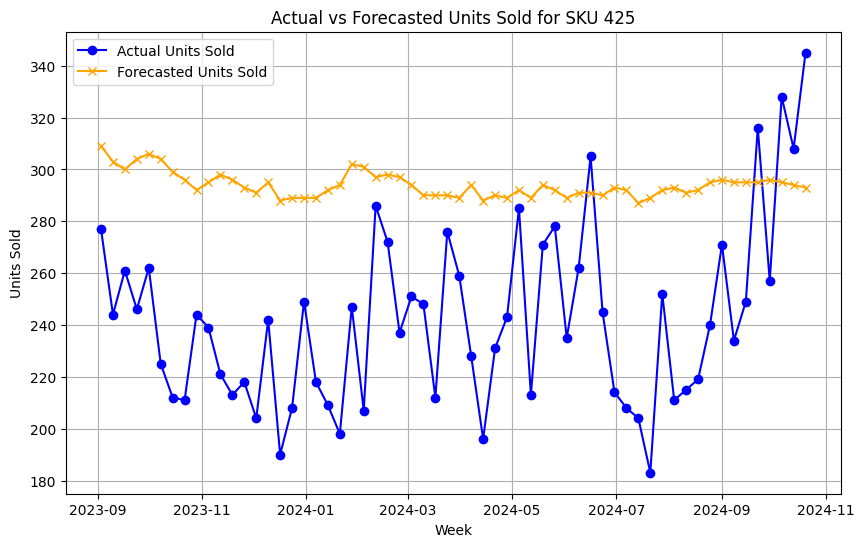

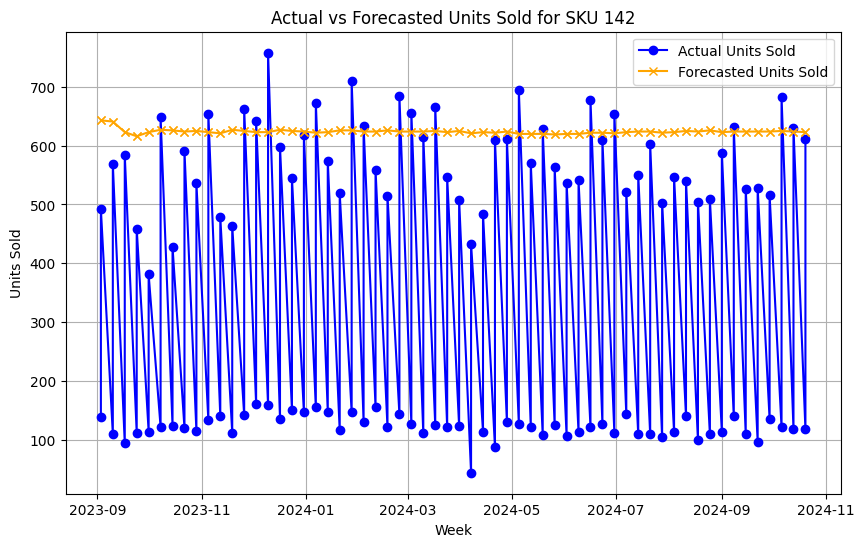

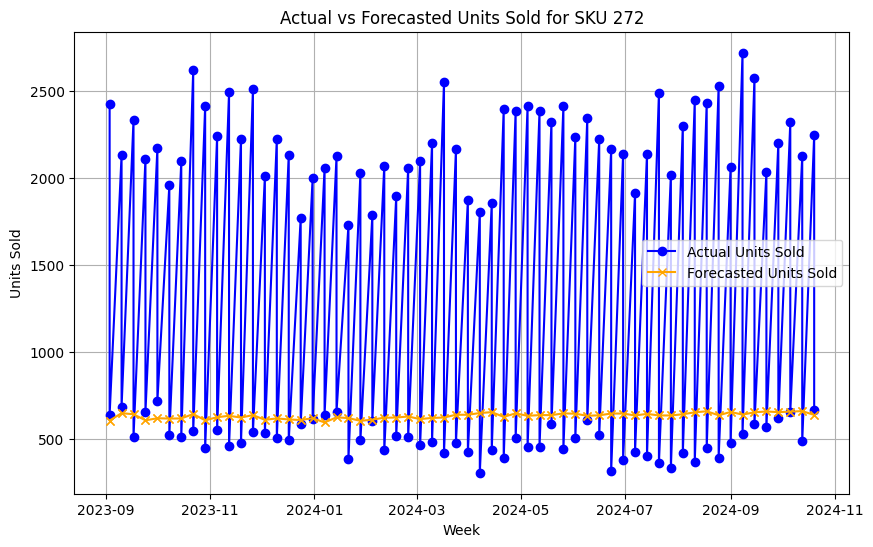

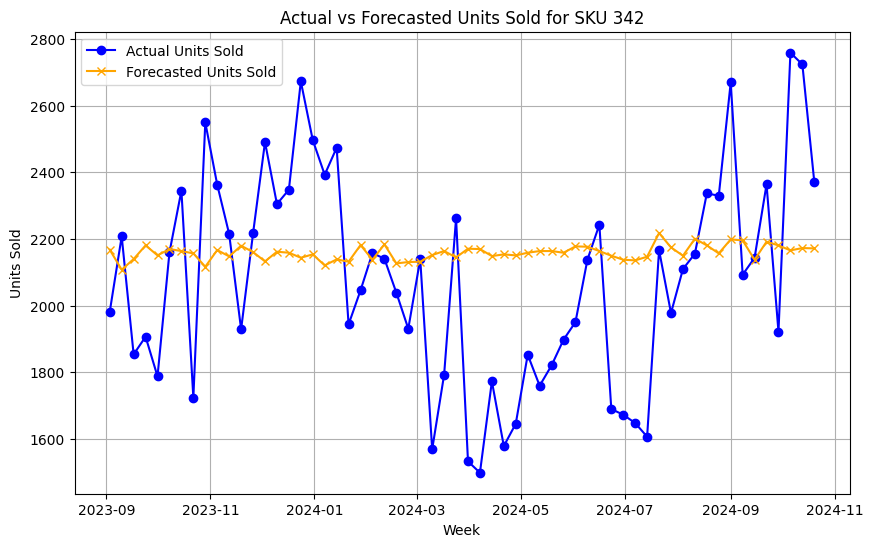

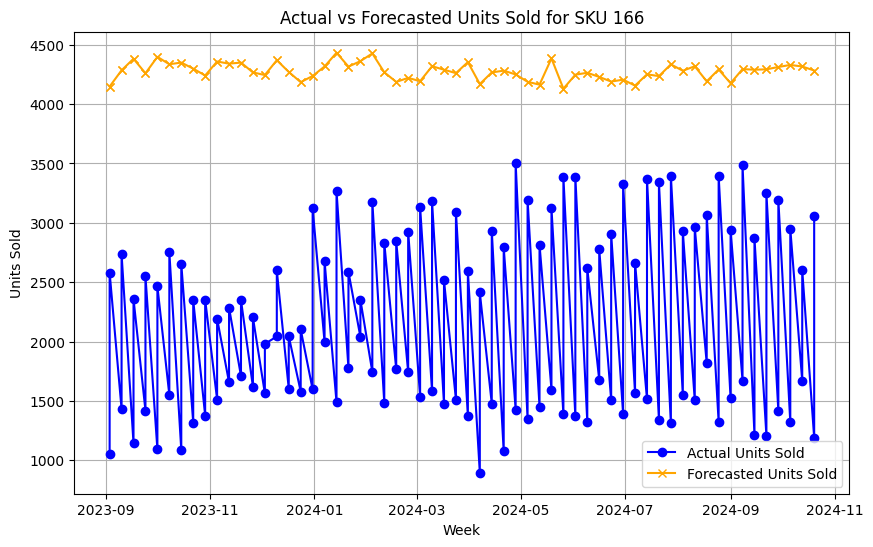

In [11]:
# Usage example
store_number = 5  # Select the store you want to analyze
# Assuming 'data' is your actual data and 'forecasted_sales' is your forecasted data
comparison_result = compare_and_plot_forecast_vs_actual(input_data, model_data, store_number)